<a href="https://colab.research.google.com/github/LiubovAnt/skolkovo_test/blob/main/z1/mapping_challenge/z1_diffusion_mapping_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Подсасываю репозиторий с кодом в colab

In [1]:
!git clone https://github.com/cloneofsimo/minDiffusion.git/

Cloning into 'minDiffusion'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (342/342), done.
remote: Compressing objects: 100% (292/292), done.
remote: Total 342 (delta 47), reused 332 (delta 44), pack-reused 0
Receiving objects: 100% (342/342), 3.59 MiB | 29.42 MiB/s, done.
Resolving deltas: 100% (47/47), done.


Подгружаю код

In [2]:
import sys

sys.path.insert(0, "/content/minDiffusion")

In [3]:
import torch

from mindiffusion.unet import NaiveUnet
from mindiffusion.ddpm import DDPM

Я начала с датасета EuroSat, но уперлась в то, что он очень разнородный и не центрированный, сгенерить что-то адекватное на простой модели не получилось. Поэтому сейчас я пробую датасет из https://www.aicrowd.com/challenges/mapping-challenge он выглядит попроще, но доступен только после регестрации. Взяла только val set, он на 60317 объектов - должно хватить. EuroSat попробую добить в отдельном файле.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
path = "/content/gdrive/MyDrive/mapping_challenge/"

In [6]:
!tar -xvzf /content/gdrive/MyDrive/mapping_challenge/data_val.tar

Streaming output truncated to the last 5000 lines.
val/images/000000027550.jpg
val/images/000000037686.jpg
val/images/000000024847.jpg
val/images/000000002847.jpg
val/images/000000040101.jpg
val/images/000000020233.jpg
val/images/000000052688.jpg
val/images/000000031210.jpg
val/images/000000003710.jpg
val/images/000000042155.jpg
val/images/000000057830.jpg
val/images/000000010974.jpg
val/images/000000027856.jpg
val/images/000000048136.jpg
val/images/000000059940.jpg
val/images/000000000562.jpg
val/images/000000038403.jpg
val/images/000000057272.jpg
val/images/000000024676.jpg
val/images/000000017573.jpg
val/images/000000058259.jpg
val/images/000000051632.jpg
val/images/000000047488.jpg
val/images/000000042097.jpg
val/images/000000045608.jpg
val/images/000000027201.jpg
val/images/000000023912.jpg
val/images/000000056930.jpg
val/images/000000028737.jpg
val/images/000000039234.jpg
val/images/000000048587.jpg
val/images/000000007004.jpg
val/images/000000013987.jpg
val/images/000000025222.j

Пишу датасет 

In [7]:
import json
import os

from torch.utils.data import Dataset
from torchvision.io import read_image


class MapDataset(Dataset):
    def __init__(self, annotations_file="/content/val/annotation.json", 
                 img_dir = "/content/val/images/", transform=None):
        with open(annotations_file) as json_file:
            self.annotation = json.load(json_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotation['images'])

    def __getitem__(self, idx):
        img_path = os.path.join(
            self.img_dir, self.annotation['images'][idx]['file_name']
        )
        image = read_image(img_path)
        label = 0
        if self.transform:
            image = self.transform(image)
        return image, label

Посмотрим

In [8]:
dataset = MapDataset()
len(dataset)

60317

<ipython-input-9-3f3b9d976442>:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  ax.imshow(image.T)


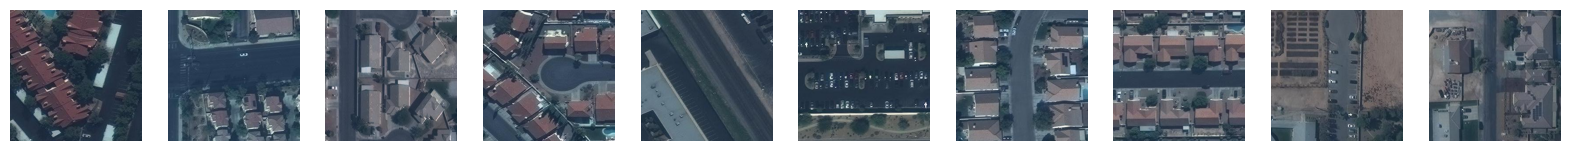

In [9]:
import random
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=10, figsize=(20, 3))
for ax in axs:
    image, label = dataset[random.randint(0, len(dataset)-1)]
    ax.imshow(image.T)
    ax.axis("off")

In [10]:
print(dataset[0][0].shape)

torch.Size([3, 300, 300])


Посчитаем статистику RGB каналам. Считать std как среднее от стандартных отклонений по batch-ам не корректно. Поэтому использую
https://stackoverflow.com/questions/10365119/mean-value-and-standard-deviation-of-a-very-huge-data-set

In [11]:
import numpy as np

from torch.utils.data import DataLoader
from tqdm import tqdm


def get_mean_and_std(dataset):
    loader = DataLoader(dataset, batch_size=512*4, shuffle=False) 
    sum_channel = 0
    squared_sum_channel = 0
    n = len(dataset) * dataset[0][0].shape[1] * dataset[0][0].shape[2]
    for images, lables in tqdm(loader):
        # sum of values
        sum_channel += images.sum(dim=(0, 2, 3))  
        # sum of squared values
        squared_sum_channel += images.pow(exponent=2).sum(dim=(0, 2, 3))  
    mean = sum_channel / n  # E[x]
    std = (squared_sum_channel / n - mean**2).sqrt()  # E[x^2] - (E[X])^2
    return mean.numpy(), std.numpy()

In [12]:
from torchvision import transforms

dataset.transform = transforms.Compose([
    transforms.Resize(64),
    transforms.Lambda(lambda t: t/255)
])
mean, std = get_mean_and_std(dataset)

print("Mean", mean)
print("STD", std)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 30/30 [01:12<00:00,  2.42s/it]

Mean [0.30483747 0.35143656 0.39739203]
STD [0.16152744 0.1497715  0.14058267]


In [13]:
dataset.transform = transforms.Compose([
    transforms.Resize(64),
    transforms.Lambda(lambda t: t/255),
    transforms.Normalize(mean, std),
])

In [14]:
import torch 

model = DDPM(eps_model=NaiveUnet(3, 3, n_feat=128), betas=(1e-4, 0.02), n_T=1000)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [15]:
!mkdir -p /content/gdrive/MyDrive/mapping_challenge/result

Код на обучение, основа https://github.com/cloneofsimo/minDiffusion/blob/master/train_cifar10.py убрала захардкоженное.

In [16]:
from torch import nn
from typing import Optional

from torchvision.utils import save_image, make_grid


def train(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: type,
    n_epoch: int = 100, 
    device: str = "cuda", 
    load_pth: Optional[str] = None
) -> None:

    for i in range(n_epoch):
        print(f"Epoch {i} : ")
        model.to(device).train()

        progress_bar = tqdm(dataloader)
        loss_ema = None
        for x, _ in progress_bar:
            optimizer.zero_grad()
            x = x.to(device)
            loss = model(x)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
            progress_bar.set_description(f"loss: {loss_ema:.4f}")
            optimizer.step()

        model.eval()
        with torch.no_grad():
            A
            xset = torch.cat([xh, x[:8]], dim=0)
            grid = make_grid(xset, normalize=True, value_range=(-1, 1), nrow=4)
            save_image(grid, f"{path}result/ddpm_sample{i}.png")

            # save model
            torch.save(model.state_dict(), f"{path}model.pth")


In [ ]:
train(model, dataloader, optimizer)

Epoch 0 : 


loss: 0.1880: 100%|██████████| 472/472 [12:05<00:00,  1.54s/it]


Epoch 1 : 


loss: 0.1456: 100%|██████████| 472/472 [12:02<00:00,  1.53s/it]


Epoch 2 : 


loss: 0.1253: 100%|██████████| 472/472 [12:03<00:00,  1.53s/it]


Epoch 3 : 


loss: 0.1221: 100%|██████████| 472/472 [12:01<00:00,  1.53s/it]


Epoch 4 : 


loss: 0.1093: 100%|██████████| 472/472 [12:03<00:00,  1.53s/it]


Epoch 5 : 


loss: 0.0962: 100%|██████████| 472/472 [12:04<00:00,  1.53s/it]


Epoch 6 : 


loss: 0.1058:  31%|███       | 147/472 [03:47<08:22,  1.55s/it]